# Random forest + temporal models

In the previous section, we loaded and processed the data for one participant,
used it to train a classifier, and tested the model on another participant.

In this section, let's make use of all the data from the 151 participants.
We will train the classifier on data from 100 participants, and set aside 51
participants for testing.

Finally, we will explore ways to account for the temporal dependency such as
mode smoothing and hidden Markov models.

## Setup

In [23]:
import os
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import scipy.stats as stats
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from joblib import Parallel, delayed
import urllib
import shutil
from tqdm.auto import tqdm
import utils  # helper functions -- check out utils.py
import zipfile
from datetime import timedelta
import seaborn as sns

# For reproducibility
np.random.seed(42)

## Process dataset

Use the following script to process the whole Capture-24 dataset.

*Note*: Alternatively, you can download the processed files by uncommenting the last paragraph in the cell below. 
We recommend this option for devices with <16 GB of RAM.  In any case, make
sure you understand the data processing below.

*This takes 3-10 minutes*

In [2]:
def load_all_and_make_windows(datafiles, N=999):

    def worker(datafile):
        X, Y, T = utils.make_windows(utils.load_data(datafile), winsec=30)
        pid = os.path.basename(datafile).split(".")[0]  # participant ID
        pid = np.asarray([pid] * len(X))
        return X, Y, T, pid

    results = Parallel(n_jobs=4)(
        delayed(worker)(datafile) for datafile in tqdm(datafiles[:N])
    )

    X = np.concatenate([result[0] for result in results])
    Y = np.concatenate([result[1] for result in results])
    T = np.concatenate([result[2] for result in results])
    pid = np.concatenate([result[3] for result in results])

    return X, Y, T, pid

# ------------------------------------------
# Uncomment below lines to process all files
# ------------------------------------------
# DATAFILES = 'capture24/P[0-9][0-9][0-9].csv.gz'
# X, Y, T, pid = load_all_and_make_windows(glob(DATAFILES))
# # Save arrays for future use
# os.makedirs("processed_data/", exist_ok=True)
# np.save("processed_data/X.npy", X)
# np.save("processed_data/Y.npy", Y)
# np.save("processed_data/T.npy", T)
# np.save("processed_data/pid.npy", pid)

# -------------------------------------------------
# Uncomment below lines to download processed files
# -------------------------------------------------
# print(f"Downloading processed files...")
# os.makedirs("processed_data/", exist_ok=True)
# url = "https://wearables-files.ndph.ox.ac.uk/files/processed_data.zip"
# with urllib.request.urlopen(url) as f_src, open(f"processed_data.zip", "wb") as f_dst:
#     shutil.copyfileobj(f_src, f_dst)
# print(f"Finished downloading")

# print("Unzipping...")
# with zipfile.ZipFile("processed_data.zip", "r") as f:
#     f.extractall(".")
# print(f"Finished unzipping")

## Download dataset

Use the following script to instead download the whole Capture-24 dataset, and extract the contents into the expected folder.

*This takes 3-10 minutes*

In [3]:
#print(f"Downloading processed files...")
#os.makedirs("processed_data/", exist_ok=True)
#url = "https://wearables-files.ndph.ox.ac.uk/files/processed_data.zip"
#with urllib.request.urlopen(url) as f_src, open(f"processed_data.zip", "wb") as f_dst:
#    shutil.copyfileobj(f_src, f_dst)
#print(f"Finished downloading")

#print("Unzipping...")
#with zipfile.ZipFile("processed_data.zip", "r") as f:
#    f.extractall(".")
#print(f"Finished unzipping")

In [4]:
# Load processed files
X_seg = np.load('processed_data/X.npy', mmap_mode='r')
Y_seg = np.load('processed_data/Y.npy')
T = np.load('processed_data/T.npy')
pid = np.load('processed_data/pid.npy')

**Exercise 1**: What is the meaning of each of the loaded processed files (`X_seg`, `Y_seg`, `T` and `pid`)? Hint: inspect the contents of each, and well as their shape.

**Exercise 2**: How many unique annotations are found in `Y_seg`?

In [5]:
print(len(pd.Series(Y_seg).dropna().unique()))

206


#### Extract features

In [6]:
def extract_base_features(xyz, T):
    ''' Extract features. xyz is an array of shape (N,3) '''

    feats = {}
    v = np.linalg.norm(xyz, axis=1)  # magnitude stream
    feats['mean'], feats['std'] = np.mean(v), np.std(v)
    feats['median'], feats['q25'], feats['q75'] = np.percentile(v, [.25, .5, .75])
    feats['IQR'], feats['range'] = feats['q75'] - feats['q25'], np.ptp(v)
    feats['hourInDay'] = pd.to_datetime(T).time().hour + pd.to_datetime(T).time().minute/60
    
    return feats

# Extract features
X_base_feats = pd.DataFrame([extract_base_features(X_seg[i], T[i]) for i in tqdm(range(len(X_seg)))])
X_base_feats.head()

  0%|          | 0/307245 [00:00<?, ?it/s]

            mean       std    median       q25       q75       IQR     range  \
0       0.970455  0.004491  0.956975  0.956975  0.956975  0.000000  0.028518   
1       0.970913  0.004386  0.956975  0.956975  0.958896  0.001921  0.029530   
2       0.971488  0.004760  0.956975  0.958779  0.958896  0.000116  0.045495   
3       0.971801  0.004613  0.958896  0.958896  0.958896  0.000000  0.030319   
4       0.971422  0.004688  0.956975  0.958896  0.958896  0.000000  0.038114   
...          ...       ...       ...       ...       ...       ...       ...   
307240  1.001827  0.004164  0.987790  0.989903  0.989903  0.000000  0.034368   
307241  1.001661  0.004419  0.982398  0.989882  0.989903  0.000021  0.034368   
307242  1.002425  0.004368  0.983488  0.983488  0.989903  0.006415  0.035456   
307243  1.000989  0.007361  0.982170  0.983488  0.983488  0.000000  0.053635   
307244  1.000819  0.007223  0.983488  0.987953  0.987953  0.000000  0.029857   

        hourInDay  
0        2.300000  

**Exercise 3**: Adjust the function above to engineer your own features!

Note the time spent extracting features from all X segments. Is this necessary every time we wish to test our code?

In [7]:
from sktime.transformations.panel.catch22 import Catch22, feature_names

def extract_catch22_features(X):
    mag = np.linalg.norm(X, axis=2)
    catch22 = Catch22().fit(mag)
    return pd.DataFrame(np.array([catch22.transform_single_feature(mag, f_name) for f_name in tqdm(feature_names)]).T,
                        columns=feature_names)

catch22_feats = extract_catch22_features(X_seg)

  0%|          | 0/22 [00:00<?, ?it/s]

In [8]:
X_feats = X_base_feats.join(catch22_feats)
X_feats.head()

,mean,std,median,q25,q75,IQR,range,hourInDay,DN_HistogramMode_5,DN_HistogramMode_10,...,IN_AutoMutualInfoStats_40_gaussian_fmmi,MD_hrv_classic_pnn40,SB_BinaryStats_mean_longstretch1,SB_MotifThree_quantile_hh,FC_LocalSimple_mean1_tauresrat,CO_Embed2_Dist_tau_d_expfit_meandiff,SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1,SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1,SB_TransitionMatrix_3ac_sumdiagcov,PD_PeriodicityWang_th0_01
0,0.970455,0.004491,0.956975,0.956975,0.956975,0.000000,0.028518,2.300000,0.965530,0.966956,...,6.0,0.0,4.0,1.941007,0.014085,31.773836,0.591837,0.714286,0.023621,0.0
1,0.970913,0.004386,0.956975,0.956975,0.958896,0.001921,0.029530,2.300000,0.965834,0.967310,...,1.0,0.0,4.0,2.017549,0.200000,36.862917,0.122449,0.755102,0.010088,0.0
2,0.971488,0.004760,0.956975,0.958779,0.958896,0.000116,0.045495,2.316667,0.971138,0.973412,...,3.0,0.0,5.0,2.066819,0.021739,35.214234,0.591837,0.857143,0.007179,0.0
3,0.971801,0.004613,0.958896,0.958896,0.958896,0.000000,0.030319,2.316667,0.977409,0.975893,...,4.0,0.0,4.0,2.072756,0.125000,35.203903,0.857143,0.755102,0.003944,0.0
4,0.971422,0.004688,0.956975,0.958896,0.958896,0.000000,0.038114,2.333333,0.975070,0.965542,...,7.0,0.0,4.0,2.063288,0.090909,38.250826,0.612245,0.836735,0.007069,0.0


#### Map annotations

As before, summarise the annotations by mapping to a reduced set of classes

In [9]:
# As before, let's map the text annotations to simplified labels
anno_label_dict = pd.read_csv(
    "capture24/annotation-label-dictionary.csv", 
    index_col='annotation', 
    dtype='string'
)
Y = anno_label_dict.loc[Y_seg, 'label:Walmsley2020'].to_numpy()

print("Label districution (# windows)")
print(pd.Series(Y).value_counts())

Label districution (# windows)
sedentary            121924
sleep                113357
light                 57124
moderate-vigorous     14840
dtype: int64


**Exercise 4**: How many hours of "bicycling" in total do we have?

In [10]:
print(timedelta(seconds=2990*30))

1 day, 0:55:00


## Train/test split

In [11]:
# Hold out participants P101-P151 for testing (51 participants)
test_ids = [f'P{i}' for i in range(101,152)]
mask_test = np.isin(pid, test_ids)
mask_train = ~mask_test
X_train, Y_train, T_train, pid_train = \
    X_feats[mask_train], Y[mask_train], T[mask_train], pid[mask_train]
X_test, Y_test, T_test, pid_test = \
    X_feats[mask_test], Y[mask_test], T[mask_test], pid[mask_test]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (205969, 30)
Shape of X_test: (101276, 30)


## Train a random forest classifier

*This may take a while*

In [32]:
# Argument oob_score=True to be used for HMM smoothing (see later below)
clf = BalancedRandomForestClassifier(
    n_estimators=1000,
    replacement=True,
    sampling_strategy='not minority',
    oob_score=True,
    n_jobs=4,
    random_state=42,
    verbose=1
)
clf.fit(X_train, Y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   30.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:   54.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:  1.1min finished


BalancedRandomForestClassifier(n_estimators=1000, n_jobs=4, oob_score=True,
                               random_state=42, replacement=True,
                               sampling_strategy='not minority', verbose=1)

**Exercise 5**: Play with the parameters of the classifier. See the [API reference](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier) for parameter descriptions.

## Model performance

In [33]:
Y_test_pred = clf.predict(X_test)
print('\nClassifier performance')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished



Classifier performance
Out of sample:
                    precision    recall  f1-score   support

            light       0.67      0.71      0.69     20736
moderate-vigorous       0.57      0.68      0.62      5994
        sedentary       0.88      0.82      0.85     37772
            sleep       0.98      0.99      0.98     36774

         accuracy                           0.85    101276
        macro avg       0.77      0.80      0.78    101276
     weighted avg       0.86      0.85      0.85    101276



Overall, the model seems to do well in distinguishing between very inactive
periods ("sit-stand" and "sleep") and very active ones ("bicycling"), but there
seems to be confusion between the remaining activities.

#### Plot predicted vs. true activity profiles

Using our utility function, let's plot the activity profile for one participant, e.g.
`P101`.

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


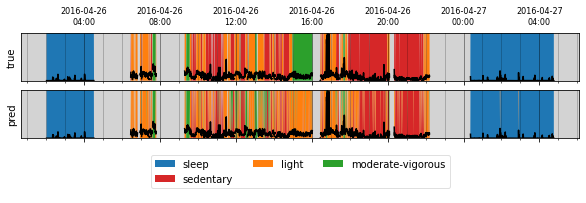

In [34]:
mask = pid_test == 'P101'
fig, axs = utils.plot_compare(T_test[mask],
                              Y_test[mask],
                              Y_test_pred[mask],
                              trace=X_test.loc[mask, 'std'])
fig.show()

The profile plots look good at first glance. After all, the majority of
activities happen to be of the sedentary type for which the model performs
well &mdash; this is reflected by the relatively high `weighted avg` scores in
the table report.
However, the `macro avg` scores are still low, and we see that the model
struggles to classify relevant activities such as bicycling and walking.
Moreover, we often find discontinuities during the sleep periods. This is
because the model is only trained to classify each window instance independently
and does not account for temporal dependencies.

## Accounting for temporal dependency

### Rolling mode smoothing
Let's use rolling mode smoothing to smooth the model predictions: Pick the
most popular label within a rolling time window.


In [35]:
def mode(alist):
    ''' Mode of a list, but return middle element if ambiguous '''
    m, c = stats.mode(alist)
    m, c = m.item(), c.item()
    if c==1:
        return alist[len(alist)//2]
    return m

def rolling_mode(t, y, window_size='100S'):
    y_dtype_orig = y.dtype
    # Hack to make it work with pandas.Series.rolling()
    y = pd.Series(y, index=t, dtype='category')
    y_code_smooth = y.cat.codes.rolling(window_size).apply(mode, raw=True).astype('int')
    y_smooth = pd.Categorical.from_codes(y_code_smooth, dtype=y.dtype)
    y_smooth = np.asarray(y_smooth, dtype=y_dtype_orig)
    return y_smooth


Classifier performance -- mode smoothing
Out of sample:
                    precision    recall  f1-score   support

            light       0.67      0.78      0.72     20736
moderate-vigorous       0.63      0.66      0.65      5994
        sedentary       0.91      0.81      0.86     37772
            sleep       0.98      0.99      0.99     36774

         accuracy                           0.86    101276
        macro avg       0.80      0.81      0.80    101276
     weighted avg       0.87      0.86      0.86    101276



Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


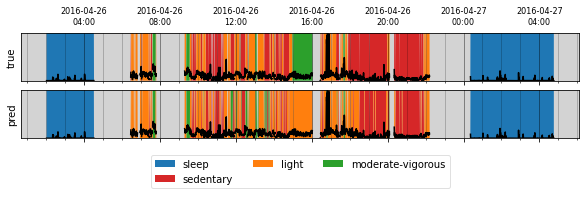

In [36]:
# Smooth the predictions of each participant
Y_test_pred_smooth = []
unqP, indP = np.unique(pid_test, return_index=True)
unqP = unqP[np.argsort(indP)]  # keep the order or else we'll scramble our arrays
for p in unqP:
    mask = pid_test == p
    Y_test_pred_smooth.append(rolling_mode(T_test[mask], Y_test_pred[mask]))
Y_test_pred_smooth = np.concatenate(Y_test_pred_smooth)

print('\nClassifier performance -- mode smoothing')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_smooth))

# Check again participant
mask = pid_test == 'P101'
fig, axs = utils.plot_compare(T_test[mask],
                              Y_test[mask],
                              Y_test_pred_smooth[mask],
                              trace=X_test.loc[mask, 'std'])
fig.show()

The simple mode smoothing already improved performance slightly.

### Hidden Markov Model

A more principled approch is to use a Hidden Markov Model (HMM). It can help
smooth the sequence of predictions and avoid weird sequences such as
"sleep"-"bicycling"-"sleep". 
Here the random forest predictions are interpreted as "observations" of the
"hidden ground truth". The emission matrix can be estimated from probabilistic
predictions of model, and the transition matrix can be estimated from the ground
truth sequence of activities. The prior probabilities can be set as the rates
observed in the dataset, or a uniform (uninformative) prior.

Check `utils.train_hmm` and `utils.viterbi` for implementationd details.

**Exercise 5**: How does random forest provide out-of-bag estimations for free?

**Exercise 6**: Why do we need out-of-bag estimations?


Classifier performance -- HMM smoothing
Out of sample:
                    precision    recall  f1-score   support

            light       0.75      0.77      0.76     20736
moderate-vigorous       0.71      0.69      0.70      5994
        sedentary       0.91      0.89      0.90     37772
            sleep       0.98      0.99      0.99     36774

         accuracy                           0.89    101276
        macro avg       0.84      0.84      0.84    101276
     weighted avg       0.89      0.89      0.89    101276



Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


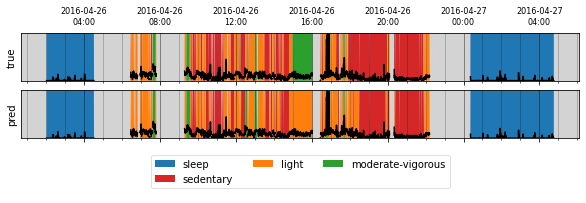

In [38]:
# Use the conveniently provided out-of-bag probability predictions from the
# random forest training process.
Y_train_prob = clf.oob_decision_function_  # out-of-bag probability predictions
labels = clf.classes_  # need this to know the label order of cols of Y_train_prob
hmm_params = utils.train_hmm(Y_train_prob, Y_train, labels)  # obtain HMM matrices/params
Y_test_pred_hmm = utils.viterbi(Y_test_pred, hmm_params)  # smoothing
print('\nClassifier performance -- HMM smoothing')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_hmm))

# Check again participant
mask = pid_test == 'P101'
fig, ax = utils.plot_compare(T_test[mask],
                             Y_test[mask],
                             Y_test_pred_hmm[mask],
                             trace=X_test.loc[mask, 'std'])
fig.show()

HMM further improves the performance scores.

## Is a simple logistic regression enough?

*This takes a while*


Classifier performance -- Logistic regression
Out of sample:
                    precision    recall  f1-score   support

            light       0.72      0.76      0.74     20736
moderate-vigorous       0.71      0.43      0.54      5994
        sedentary       0.84      0.89      0.86     37772
            sleep       0.97      0.94      0.95     36774

         accuracy                           0.85    101276
        macro avg       0.81      0.75      0.77    101276
     weighted avg       0.85      0.85      0.85    101276



Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


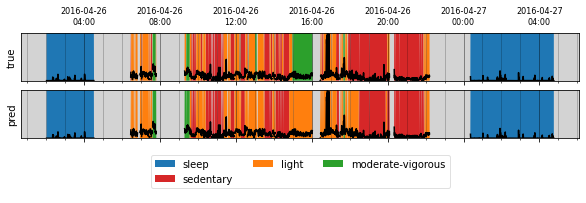

In [39]:
clf_LR = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    random_state=42)
scaler = StandardScaler()
pipe = make_pipeline(scaler, clf_LR)
pipe.fit(X_train, Y_train)

Y_test_pred_LR = pipe.predict(X_test)

# HMM smoothing
Y_train_LR_prob = pipe.predict_proba(X_train)  # sorry! LR doesn't provide OOB estimates for free
labels = pipe.classes_
hmm_params_LR = utils.train_hmm(Y_train_LR_prob, Y_train, labels)
Y_test_pred_LR_hmm = utils.viterbi(Y_test_pred_LR, hmm_params_LR)  # smoothing

print('\nClassifier performance -- Logistic regression')
print('Out of sample:\n', metrics.classification_report(Y_test, Y_test_pred_LR_hmm))

# Check again participant
mask = pid_test == 'P101'
fig, axs = utils.plot_compare(T_test[mask],
                      Y_test[mask],
                      Y_test_pred_LR_hmm[mask],
                      trace=X_test.loc[mask, 'std'])
fig.show()

The LR model performed well on the easier classes "sleep" and "sit-stand",
but was much worse on all the other classes.

# Feature importance

<AxesSubplot:>

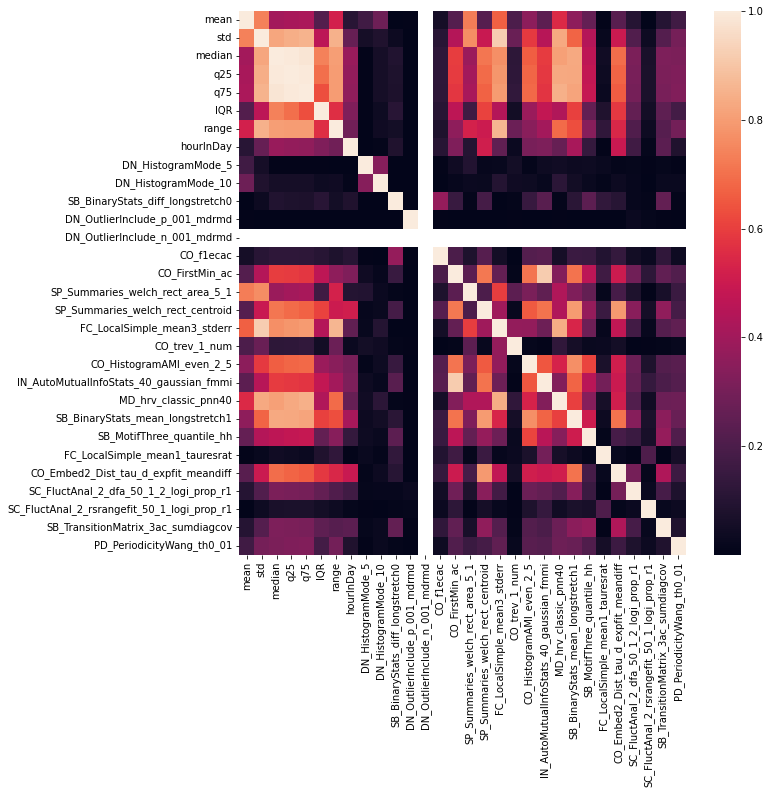

In [40]:
plt.figure(figsize=(10,10))
sns.heatmap(X_feats.corr().abs())

<AxesSubplot:>

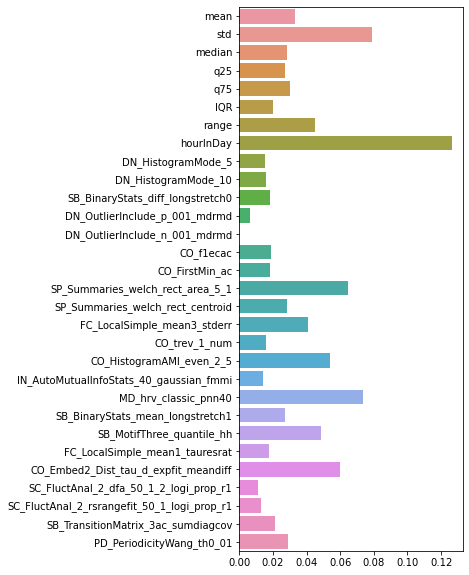

In [41]:
plt.figure(figsize=(4,10))
sns.barplot(x=clf.feature_importances_, y=X_feats.columns)

In [ ]:
import shap
explainer = shap.TreeExplainer(clf, X_test)
shap.summary_plot(explainer.shap_values(X_test[0:1000]), X_test[0:1000])

  0%|                   | 47/405104 [00:55<7900:02]       